In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os

from neuroinference.utils import deviance_poisson, selection_accuracy
from pyuoi.utils import log_likelihood_glm, AIC, BIC
from sklearn.metrics import log_loss
%matplotlib inline

/Users/psachdeva/opt/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/psachdeva/opt/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/psachdeva/opt/anaconda3/envs/neuro/lib/python3.7/site-packages/sklearn/utils/deprecat

In [2]:
# Load fits
base_path = "/Volumes/pss/fits/neuroinference/synthetic/logistic"
files = os.listdir(base_path)

In [3]:
# Import true parameters
with h5py.File(os.path.join(base_path, files[0]), 'r') as results:
    beta = results['beta'][:]
    intercept = results['intercept'][:].item()

In [4]:
# Instantiate storage arrays
n_datasets = 30
n_features = beta.size
beta_uoi = np.zeros((n_datasets, n_features))
beta_base = np.zeros_like(beta_uoi)
intercept_uoi = np.zeros(n_datasets)
intercept_base = np.zeros_like(intercept_uoi)
ll_uoi = np.zeros(n_datasets)
ll_base = np.zeros_like(ll_uoi)
sel_acc_uoi = np.zeros(n_datasets)
sel_acc_base = np.zeros(n_datasets)
bic_uoi = np.zeros(n_datasets)
bic_base = np.zeros(n_datasets)

In [5]:
# Obtain test set
n_samples = 1200
rng = np.random.default_rng(943813)
X_test = rng.uniform(low=-1, high=1, size=(n_samples, n_features))
prob = 1. / (1 + np.exp(-(intercept + X_test @ beta)))
y_test = (rng.uniform(low=0, high=1, size=n_samples) < prob).astype('int')

In [6]:
# Populate fits
for idx, file in enumerate(files):
    path = os.path.join(base_path, file)
    with h5py.File(path, 'r') as results:
        beta_uoi[idx] = results['beta_uoi'][:]
        beta_base[idx] = results['beta_base'][:]
        intercept_uoi[idx] = results['intercept_uoi'][:].item()
        intercept_base[idx] = results['intercept_base'][:].item()
        # Calculate estimates
        y_test_uoi = 1. / (1 + np.exp(-(intercept_uoi[idx] + X_test @ beta_uoi[idx])))
        y_test_base = 1. / (1 + np.exp(-(intercept_base[idx] + X_test @ beta_base[idx])))
        # Selection accuracy
        sel_acc_uoi[idx] = selection_accuracy(beta, beta_uoi[idx])
        sel_acc_base[idx] = selection_accuracy(beta, beta_base[idx])
        # BIC
        X_train = results['X'][:]
        y_train = results['y'][:]
        ll_uoi[idx] = log_loss(y_true=y_test, y_pred=y_test_uoi)
        ll_base[idx] = log_loss(y_true=y_test, y_pred=y_test_base)
        bic_uoi[idx] = BIC(
            log_loss(y_true=y_train, y_pred=1. / (1 + np.exp(-(intercept_uoi[idx] + X_train @ beta_uoi[idx])))),
            np.count_nonzero(beta_uoi[idx]),
            n_samples)
        bic_base[idx] = BIC(
            log_loss(y_true=y_train, y_pred=1. / (1 + np.exp(-(intercept_base[idx] + X_train @ beta_base[idx])))),
            np.count_nonzero(beta_base[idx]),
            n_samples)

In [7]:
# Estimation error
est_error_uoi = np.mean((beta_uoi - beta)**2, axis=1)
est_error_base = np.mean((beta_base - beta)**2, axis=1)
# Estimation variability
est_var_uoi = np.std(beta_uoi, axis=0)
est_var_base = np.std(beta_base, axis=0)

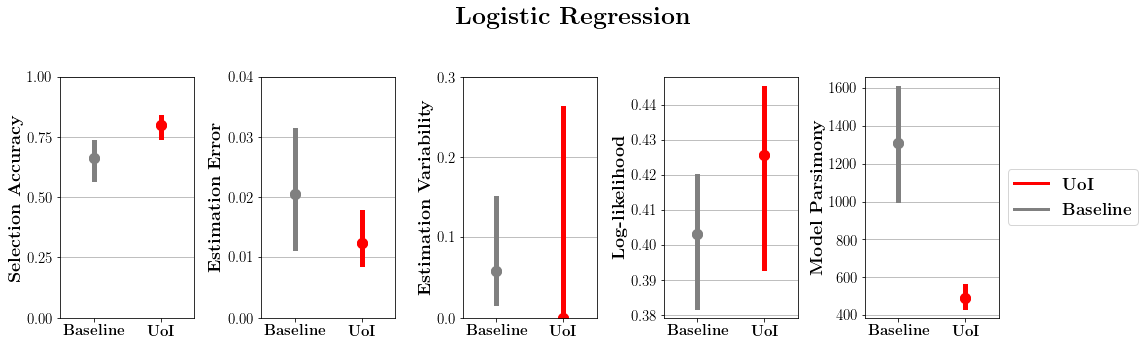

In [28]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

# Selection accuracy
axes[0].boxplot(
    x=[sel_acc_base],
    positions=[0],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'gray', 'markersize': 10},
    boxprops={'color': 'gray', 'linewidth': 5},
    whiskerprops={'color': 'gray', 'linewidth': 5}   
)
axes[0].boxplot(
    x=[sel_acc_uoi],
    positions=[1],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'red', 'markersize': 10},
    boxprops={'color': 'red', 'linewidth': 5},
    whiskerprops={'color': 'red', 'linewidth': 5}   
)
axes[0].set_ylim([0, 1])
axes[0].set_yticks([0, 0.25, 0.50, 0.75, 1.0])
axes[0].set_ylabel(r'\textbf{Selection Accuracy}', fontsize=18)

# Estimation error
axes[1].boxplot(
    x=[est_error_base],
    positions=[0],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'gray', 'markersize': 10},
    boxprops={'color': 'gray', 'linewidth': 5},
    whiskerprops={'color': 'gray', 'linewidth': 5}   
)
axes[1].boxplot(
    x=[est_error_uoi],
    positions=[1],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'red', 'markersize': 10},
    boxprops={'color': 'red', 'linewidth': 5},
    whiskerprops={'color': 'red', 'linewidth': 5}   
)
axes[1].set_ylim([0, 0.04])
axes[1].set_yticks([0, 0.01, 0.02, 0.03, 0.04])
axes[1].set_ylabel(r'\textbf{Estimation Error}', fontsize=18)

# Estimation variability
axes[2].boxplot(
    x=[est_var_base],
    positions=[0],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'gray', 'markersize': 10},
    boxprops={'color': 'gray', 'linewidth': 5},
    whiskerprops={'color': 'gray', 'linewidth': 5}   
)
axes[2].boxplot(
    x=[est_var_uoi],
    positions=[1],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'red', 'markersize': 10},
    boxprops={'color': 'red', 'linewidth': 5},
    whiskerprops={'color': 'red', 'linewidth': 5}   
)
axes[2].set_ylim([0, 0.30])
axes[2].set_yticks([0, 0.1, 0.20, 0.30])
axes[2].set_ylabel(r'\textbf{Estimation Variability}', fontsize=18)

# Estimation variability
axes[3].boxplot(
    x=[ll_base],
    positions=[0],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'gray', 'markersize': 10},
    boxprops={'color': 'gray', 'linewidth': 5},
    whiskerprops={'color': 'gray', 'linewidth': 5}   
)
axes[3].boxplot(
    x=[ll_uoi],
    positions=[1],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'red', 'markersize': 10},
    boxprops={'color': 'red', 'linewidth': 5},
    whiskerprops={'color': 'red', 'linewidth': 5}   
)
axes[3].set_ylabel(r'\textbf{Log-likelihood}', fontsize=18)


# Model Parsimony
axes[4].boxplot(
    x=[bic_base],
    positions=[0],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'gray', 'markersize': 10},
    boxprops={'color': 'gray', 'linewidth': 5},
    whiskerprops={'color': 'gray', 'linewidth': 5}
)
axes[4].boxplot(
    x=[bic_uoi],
    positions=[1],
    showfliers=False,
    widths=0,
    medianprops={'marker': 'o', 'color': 'red', 'markersize': 10},
    boxprops={'color': 'red', 'linewidth': 5},
    whiskerprops={'color': 'red', 'linewidth': 5}
)
axes[4].set_ylabel(r'\textbf{Model Parsimony}', fontsize=18)
axes[4].plot([], [], color='r', linewidth=3, label=r'\textbf{UoI}')
axes[4].plot([], [], color='grey', linewidth=3, label=r'\textbf{Baseline}')
axes[4].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 17})

for ax in axes:
    ax.set_xticklabels([r'\textbf{Baseline}', r'\textbf{UoI}'])
    ax.tick_params(labelsize=15)
    ax.grid(axis='y', linestyle='-')

fig.text(
    x=0.5, y=1.15, ha='center', va='center',
    s=r'\textbf{Logistic Regression}',
    fontsize=25
)
plt.tight_layout()
plt.savefig('synthetic_logistic.pdf', bbox_inches='tight')